In [1]:
import pyspark as ps
import numpy as np
import pandas as pd
from pyspark import SQLContext
from pyspark.ml import Pipeline
import pyspark.sql.functions as func
from pyspark.ml.feature import RegexTokenizer, HashingTF, Binarizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as mpl
import seaborn as sns


%matplotlib inline

In [2]:
spark = ps.sql.SparkSession.builder\
    .master('local[4]')\
    .appName('Project1')\
    .getOrCreate()

sc = spark.sparkContext

In [3]:
sqlContext = SQLContext(sc)

In [4]:
df = sqlContext.read.csv('../../data/fifa.csv',
                         header=True,
                         quote='"',
                         sep=',',
                         inferSchema=True)
spark.conf.set("spark.sql.execution.arrow.enabled", "false")

In [5]:
filtered_df = df[[
    'ID',
    'Name',
    'Age',
    'Nationality',
    'Overall',
    'Potential',
    'Club',
    'Value',
    'International Reputation',
    'Release Clause'
]]

In [6]:
filtered_df.show(5)

+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|    ID|             Name|Age|Nationality|Overall|Potential|               Club|  Value|International Reputation|Release Clause|
+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|158023|         L. Messi| 31|  Argentina|     94|       94|       FC Barcelona|€110.5M|                       5|       €226.5M|
| 20801|Cristiano Ronaldo| 33|   Portugal|     94|       94|           Juventus|   €77M|                       5|       €127.1M|
|190871|        Neymar Jr| 26|     Brazil|     92|       93|Paris Saint-Germain|€118.5M|                       5|       €228.1M|
|193080|           De Gea| 27|      Spain|     91|       93|  Manchester United|   €72M|                       4|       €138.6M|
|192985|     K. De Bruyne| 27|    Belgium|     91|       92|    Manchester City|  €102M|         

In [7]:
ordered_df = filtered_df.orderBy("Overall", ascending=False).toPandas()

Min: 46
Max: 94
Lower quartile: 62.0
Median: 66.0
Upper quartile: 71.0


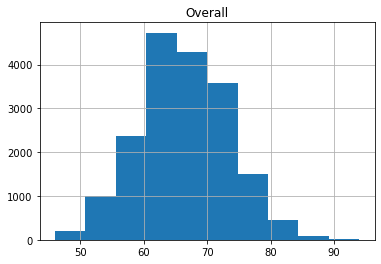

In [8]:
ordered_df.hist(['Overall'])
overall = filtered_df.select('Overall').collect()
print("Min:", np.min(overall))
print("Max:", np.max(overall))
print("Lower quartile:", np.percentile(overall, 25))
print("Median:", np.percentile(overall, 50))
print("Upper quartile:", np.percentile(overall, 75))
mpl.show()

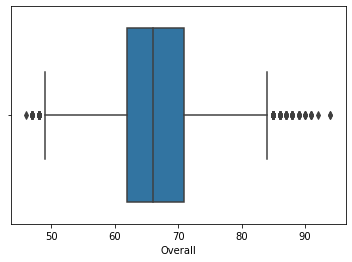

In [9]:
ax = sns.boxplot(x=ordered_df['Overall'])
mpl.show()

In [10]:
df = spark.createDataFrame(ordered_df).orderBy('Potential', ascending=False).limit(50)

In [11]:
df.show()

+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|    ID|             Name|Age|Nationality|Overall|Potential|               Club|  Value|International Reputation|Release Clause|
+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|231747|        K. Mbappé| 19|     France|     88|       95|Paris Saint-Germain|   €81M|                     3.0|       €166.1M|
|158023|         L. Messi| 31|  Argentina|     94|       94|       FC Barcelona|€110.5M|                     5.0|       €226.5M|
| 20801|Cristiano Ronaldo| 33|   Portugal|     94|       94|           Juventus|   €77M|                     5.0|       €127.1M|
|211110|        P. Dybala| 24|  Argentina|     89|       94|           Juventus|   €89M|                     3.0|       €153.5M|
|190871|        Neymar Jr| 26|     Brazil|     92|       93|Paris Saint-Germain|€118.5M|         

In [12]:
df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: long (nullable = true)
 |-- Potential: long (nullable = true)
 |-- Club: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- International Reputation: double (nullable = true)
 |-- Release Clause: string (nullable = true)



In [13]:
ml_asm = VectorAssembler(
    inputCols=['Age', 'Overall', 'Potential', 'International Reputation'],
    outputCol='Features'
)
ml_vasm = ml_asm.transform(df)

In [14]:
ml_vasm.select(['ID', 'Name', 'Features']).show(5)

+------+-----------------+--------------------+
|    ID|             Name|            Features|
+------+-----------------+--------------------+
|231747|        K. Mbappé|[19.0,88.0,95.0,3.0]|
|158023|         L. Messi|[31.0,94.0,94.0,5.0]|
| 20801|Cristiano Ronaldo|[33.0,94.0,94.0,5.0]|
|211110|        P. Dybala|[24.0,89.0,94.0,3.0]|
|190871|        Neymar Jr|[26.0,92.0,93.0,5.0]|
+------+-----------------+--------------------+
only showing top 5 rows



In [15]:
df_parts = ml_vasm.randomSplit([0.7, 0.3])
training_df = df_parts[0]
testing_df = df_parts[1]

In [16]:
training_df.describe(['Name', 'Age', 'Overall', 'Potential', 'International Reputation']).show(20)

+-------+---------------+------------------+------------------+------------------+------------------------+
|summary|           Name|               Age|           Overall|         Potential|International Reputation|
+-------+---------------+------------------+------------------+------------------+------------------------+
|  count|             34|                34|                34|                34|                      34|
|   mean|           null|25.176470588235293| 87.02941176470588|  91.3529411764706|                     3.0|
| stddev|           null| 4.011125348292525|3.7212354914581476|1.4746823580151063|      1.0730867399773196|
|    min|   A. Griezmann|                17|                77|                90|                     1.0|
|    max|Vinícius Júnior|                33|                94|                95|                     5.0|
+-------+---------------+------------------+------------------+------------------+------------------------+



In [17]:
testing_df.describe(['Age', 'Overall', 'Potential', 'International Reputation']).show(20)

+-------+-----------------+-----------------+-----------------+------------------------+
|summary|              Age|          Overall|        Potential|International Reputation|
+-------+-----------------+-----------------+-----------------+------------------------+
|  count|               16|               16|               16|                      16|
|   mean|          24.1875|          86.5625|          90.8125|                     3.0|
| stddev|3.727711541057506|4.098271993576481|0.910585891976516|      1.0954451150103321|
|    min|               18|               78|               90|                     1.0|
|    max|               32|               92|               93|                     5.0|
+-------+-----------------+-----------------+-----------------+------------------------+



In [18]:
ml_lr = LinearRegression(
    featuresCol="Features",
    labelCol="Potential",
    predictionCol="Predected Pontential"
)

ml_lr_model = ml_lr.fit(training_df)

In [19]:
ml_lr_predicts = ml_lr_model.transform(testing_df)

In [20]:
ml_lr_predicts.select(['Name', 'Age', 'Overall', 'Potential', 'International Reputation', 'Predected Pontential']).show(50)

+--------------+---+-------+---------+------------------------+--------------------+
|          Name|Age|Overall|Potential|International Reputation|Predected Pontential|
+--------------+---+-------+---------+------------------------+--------------------+
|     L. Modrić| 32|     91|       91|                     4.0|    90.9999999999995|
|     E. Hazard| 27|     91|       91|                     4.0|   91.00000000000152|
|R. Lewandowski| 29|     90|       90|                     4.0|   90.00000000000205|
|     Neymar Jr| 26|     92|       93|                     5.0|   93.00000000000034|
|   T. Courtois| 26|     89|       90|                     4.0|   90.00000000000313|
|      P. Pogba| 25|     87|       91|                     4.0|   91.00000000000185|
|     M. Icardi| 25|     87|       90|                     3.0|   90.00000000000207|
|       H. Kane| 24|     89|       91|                     3.0|   91.00000000000126|
|          Saúl| 23|     85|       90|                     3.0|  